Información integrantes del equipo de trabajo

**Nombre y apellidos (Grupo):** Elodie Curcio

**Nombre y apellidos (Grupo):** Guillermo Díaz

**Nombre y apellidos (Grupo):** Miguel Quiroga

# Random walk


## Apartado a:

- Considerar una caminata aleatoria en 1D con pasos de tamaño 1. Definid una función que tome como entrada el punto de partida y el número de pasos, $N$, a realizar en la caminata y devuelva la trayectoria completa del caminante. Definid la función de tal forma que pueda introducirse un array como punto inicial, de forma que se simulen en paralelo más de un caminante. Con esta función obtened el camino aleatorio seguido por $M=1000$ caminantes.

- Representar la posición de varios de los caminantes en función de los pasos dados (tomad $N$ del orden de 100000).


In [78]:
# Librerias
from pylab import plot, show, hist, title, xlabel, ylabel, legend, axis, hist2d, errorbar
from numpy import zeros, exp, histogram, ndarray, linspace, arange, std, array, save, load
from numpy.random import randint
from scipy.optimize import curve_fit as fit
from scipy.stats import t
from tqdm import trange
from IPython.display import clear_output

In [79]:
def randomStep(moves: ndarray, pos: int) -> ndarray:
    """
    Evolución de un solo paso para N caminantes en 1-D.

    Inputs
    ------
    moves : ndarray
        Array pre-inicializado donde almacenar las posiciones.
    pos : int
        Iteración / paso actual.

    Outputs
    -------
    moves : ndarray
        Array de posiciones actualizado para el paso correspondiente.

    """
    moves[:, pos+1] = moves[:, pos] + ((-1)**randint(0, 2, moves[:, pos].size))
    return moves

def randomWalk1D(people: int, steps: int) -> ndarray:
    """
    Evolución completa de N caminantes en 1-D.

    Inputs
    ------
    people : int
        Cantidad de caminantes.
    steps : int
        Cantidad de pasos.
    
    Outputs
    -------
    moves : ndarray
        Array de posiciones en cada paso.
    """
    moves = zeros([people, steps], int)
    for i in trange(steps-1, desc='pasos'):
        moves = randomStep(moves, i)
    return moves

def plotWalk1D(moves: ndarray, people: int = 5):
    """
    Representa los movimientos de `people` cantidad de caminatnes.    
    """
    for i in range(people):
        plot(moves[i,:])
    xlabel('Pasos')
    ylabel('$x$')
    title(f'Evolución de {people} caminantes')
    show()

pasos: 100%|██████████| 99999/99999 [00:02<00:00, 47452.61it/s]


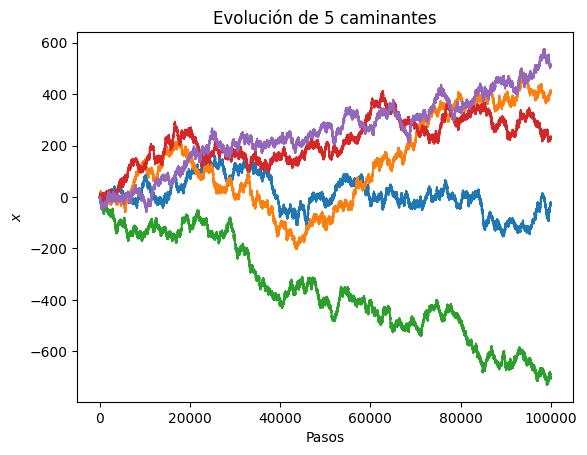

In [80]:
steps = 100000
people = 1000
moves1D = randomWalk1D(people, steps)
plotWalk1D(moves1D)

- A partir de los datos obtenidos, para un cierto paso (por ejemplo el paso 2000), obtened el histograma de la posición de los caminantes.
- Ajustad los datos obtenidos a una distribución gaussiana y obtened la media y la desviación estandar de la distribución.

In [81]:
def stepsGaussian(x: float | ndarray, stdev: float, mean: float, amp: float) -> float | ndarray:
    """
    PDF no normalizada de una distrubución gaussiana.

    Inputs
    ------
    x : float or ndarray
        Variable aleatoria.
    stdev : float
        Desviación estándar de la distribución.
    mean : float
        Media de la distribución.
    amp : float
        Amplitud de la distribución.

    Outputs
    -------
    float or ndarray
        Probabilidad.
    """
    val = (x-mean)**2 / (2*stdev**2)
    return exp(-val)*amp

def fitGaussian(moves: ndarray, stdGuess: float = 10000**0.5, bins: int = 20) -> tuple[float, float, float, ndarray, ndarray]:
    """
    Ajusta los datos de los caminantes a una distribución gaussiana.

    Inputs
    ------
    moves : ndarray
        Array de posiciones de los caminantes.
    stdGuess : float
        Estimación inicial de la desviación estándar.
    bins : int
        Columnas de datos.

    Outputs
    -------
    stdev : float
        Desviación estándar ajustada.
    mean : float
        Media ajustada.
    amplitude : float
        Amplitud ajustada.
    xdata, ydata : ndarray
        Datos para el histograma.
    """
    ydata, xdata = histogram(moves, bins)
    initGuess = (stdGuess, 0, 100) # muy importante para asegurar la estabilidad de la solución ajustada
    stdev, mean, amplitude = fit(stepsGaussian, xdata[0:xdata.size-1], ydata, initGuess)[0][:]
    return stdev, mean, amplitude, xdata, ydata

def histSteps1D(moves: ndarray, stdGuess: float = 10000**0.5, bins: int = 20, desc = ''):
    """
    Representa y ajusta los datos de los caminantes a una distribución gaussiana.
    
    Inputs
    ------
    moves : ndarray
        Array de posiciones de los caminantes.
    stdGuess : float
        Estimación inicial de la desviación estándar.
    bins : int
        Columnas de datos.
    desc : str
        Descripción para añadir al título de la gráfica.
    """
    stdev, mean, amp, xdata, ydata = fitGaussian(moves, stdGuess, bins)
    limUp = xdata.max()
    limDn = xdata.min()
    x = linspace(limDn,limUp,100)
    hist(moves, bins)
    plot(x, stepsGaussian(x, stdev, mean, amp))
    xlabel('$x$')
    ylabel('Frecuencia')
    title(f'{desc}Distribución con $\sigma =$ {round(abs(stdev),2)}, $\mu =$ {round(mean,2)}')
    show()


pasos: 100%|██████████| 9999/9999 [00:00<00:00, 45779.37it/s]


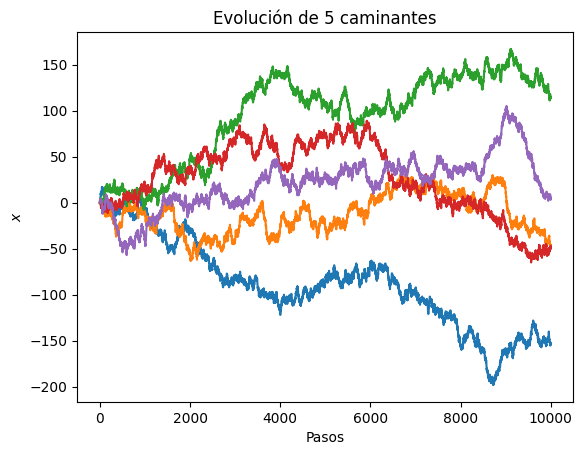

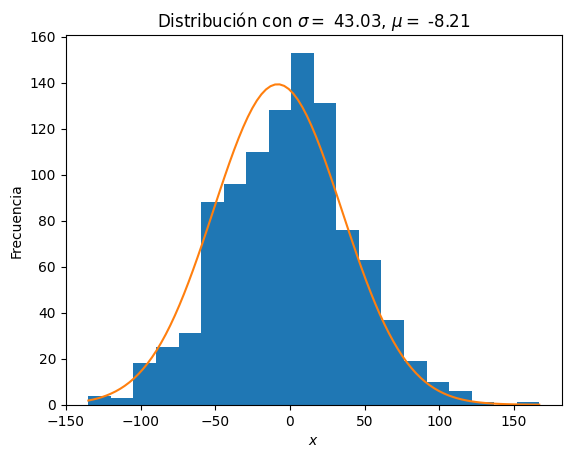

In [82]:
steps = 10000
people = 1000
moves1D = randomWalk1D(people, steps)
plotWalk1D(moves1D)
step = 2000
histSteps1D(moves1D[:,step-1], stdGuess=step**0.5)

- Usando los datos obtenidos, obtener la desviación estandar de los datos para cada paso de tiempo, es decir, la desviación estandar como función del número de pasos.
- Realizar un ajuste de los datos a una función de la forma $f(x)=Ax^b$, y superponer el ajuste. Comprobad que se cumple que $STD(n)\simeq \sqrt{n}$, siendo $n$ el número de pasos dados.

In [83]:
def expectedStd(step: float | ndarray, amp: float, expn: float) -> float | ndarray:
    """
    Función que describe la desviación estándar de la posición de los caminantes: `f = A·e^b`.
    """
    return amp*step**expn

def stepStd(moves: ndarray) -> list:
    """
    Calcula la desviación estándar de la posición de los caminantes en cada paso.
    """
    steps = moves.shape[1]
    stdev = []
    for i in range(steps):
        stdev.append(std(moves[:,i]))
    return stdev

def fitStd(moves: ndarray, plt: bool = True) -> tuple[float, float]:
    """
    Ajusta las desviaciones estándar de la posición de los caminantes en cada paso a la función `expectedStd`.

    Inputs
    ------
    moves : ndarray
        Array de posiciones de los caminantes.
    plt : bool
        Indicador para representar los resultados.

    Outputs
    -------
    amp : float
        Amplitud de la función `expectedStd`.
    expn : float
        Exponente de la función `expectedStd`.
    """
    steps = moves.shape[1]
    stdev = stepStd(moves)
    stepLin = arange(0,steps,1)
    initGuess = (1, 0.5)
    amp, expn = fit(expectedStd, stepLin, stdev, initGuess)[0][:]

    if plt:
        plot(stepLin, stdev, label='Experimental')
        plot(stepLin, expectedStd(stepLin, 1, 0.5), label='Teórico')
        plot(stepLin, expectedStd(stepLin, amp, expn), 'k--', label='Ajuste')
        xlabel('Pasos')
        ylabel('$\sigma$')
        title(f'Ajuste con $A =$ {round(amp,2)}, $b =$ {round(expn,2)}')
        legend()
        show()
    return amp, expn


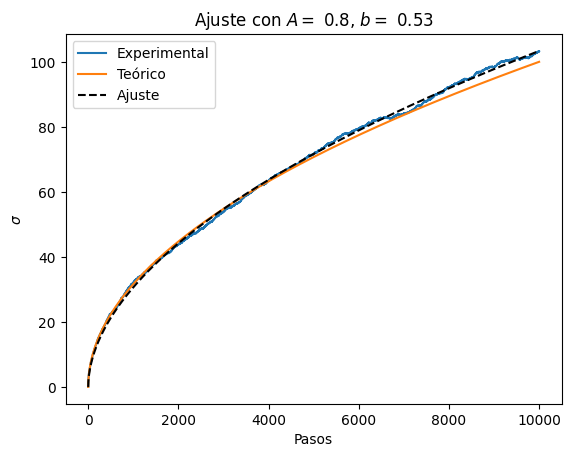

In [84]:
amp, expn = fitStd(moves1D)

## Apartado b:

- Definir una nueva función que tome como entrada el punto inicial y el numero de pasos para una caminata aleatoria en un retículo en dos dimensiones, es decir, ahora podemos movernos una distancia 1 en la dirección $x$ o $y$. La función devolverá el recorrido de los caminantes.
- Representar para algunos caminantes las trayectorias seguidas tras dar $N=100000$ pasos

In [85]:
def randomWalk2DSingle(x0: int, y0: int, steps: int) -> tuple[ndarray, ndarray]:
    """
    Calcula la evolución de un caminante en 2D.

    Inputs
    ------
    x0, y0 : int
        Posición inicial del caminante en cada eje.
    steps : int
        Cantidad total de pasos / iteraciones.
    
    Outputs
    -------
    x, y : ndarray
        Posiciones en cada eje para cada paso.
    """
    x = zeros([steps], int)
    x[0] = x0
    y = zeros([steps], int)
    y[0] = y0
    for i in range(steps-1):
        if randint(0,2) == 0:
            x[i+1] = x[i] + (-1)**randint(0,2)
            y[i+1] = y[i]
        else:
            x[i+1] = x[i]
            y[i+1] = y[i] + (-1)**randint(0,2)
    return x, y

def randomWalk2D(x0: ndarray, y0: ndarray, steps: int) -> ndarray:
    """
    Calcula la evolución de N caminantes en 2D utilizando `randomWalk2DSingle`.

    Inputs
    ------
    x0, y0 : ndarray
        Posiciones iniciales de los caminantes en cada eje. El tamaño del array unidimensional indica la cantidad de caminantes.
    steps : int
        Cantidad total de pasos / iteraciones.

    Outputs
    -------
    moves : ndarray
        Array de posiciones de los caminantes.
    """
    people = x0.size
    moves = zeros([people,2,steps])
    for i in trange(people, desc='caminantes'):
        x, y = randomWalk2DSingle(x0[i], y0[i], steps)
        moves[i,0,:] = x
        moves[i,1,:] = y
    return moves

def plotWalk2D(moves: ndarray):
    """
    Representa los movimientos de todos los caminantes.
    """
    people = moves.shape[0]
    for i in range(people):
        plot(moves[i,0,:],moves[i,1,:])
    
    for i in range(people): # en otro bucle para que queden por encima de los caminos
        plot(moves[i,0,0], moves[i,1,0], 'k*')
    
    xlabel('$x$')
    ylabel('$y$')
    title(f"Evolución de {people} caminante{'s'*bool(people-1)}")   # añade el plural automáticamente (completamente innecesario, pero está guay)
    axis('equal')
    show()

def randomPosInit(people: int, lim: int) -> tuple[ndarray, ndarray]:
    """
    Inicializa aleatoriamente las posiciones de `people` caminantes.

    Inputs
    ------
    people : int
        Cantidad de caminantes a inicializar.
    lim : int
        Límite positivo y negativo para la posición inicial en ambos ejes.

    Outputs
    -------
    x0, y0 : ndarray
        Posiciones iniciales de los caminantes en cada eje. El tamaño del array unidimensional indica la cantidad de caminantes.
    """
    x0 = randint(-lim, lim+1, people)
    y0 = randint(-lim, lim+1, people)
    return x0, y0

caminantes: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


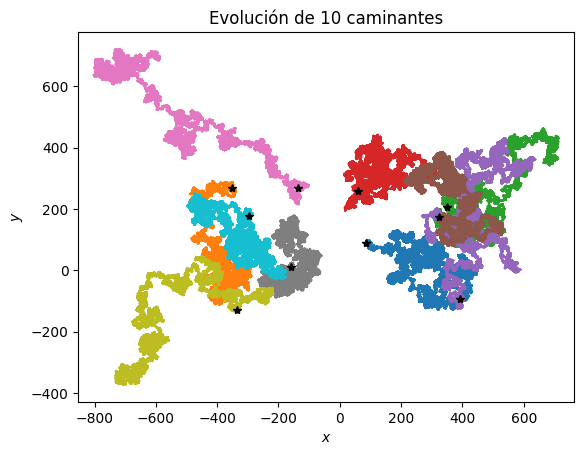

In [86]:
steps = 100000
x0, y0 = randomPosInit(10, 400)
moves2D = randomWalk2D(x0, y0, steps)

plotWalk2D(moves2D)

- Considerar un numero de pasos fijo, y obtener el histograma de la posición $x$ del caminante, y ajustar los resultados a una función gaussiana. Haced lo mismo para la posición en $y$.

caminantes: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


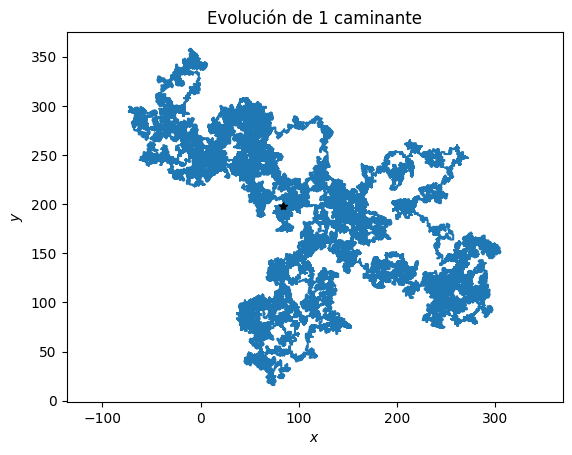

Posición inicial: (x=[84], y=[198])


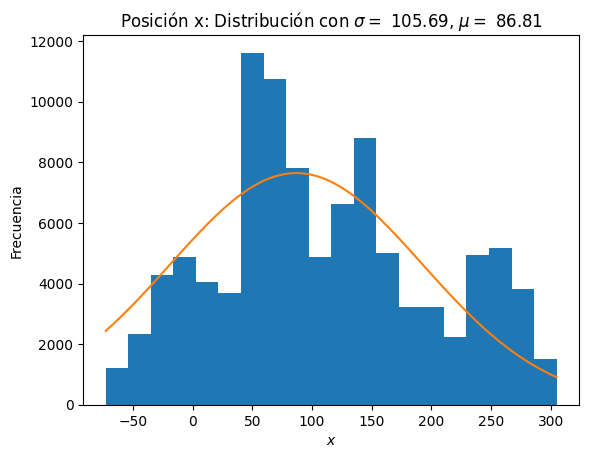

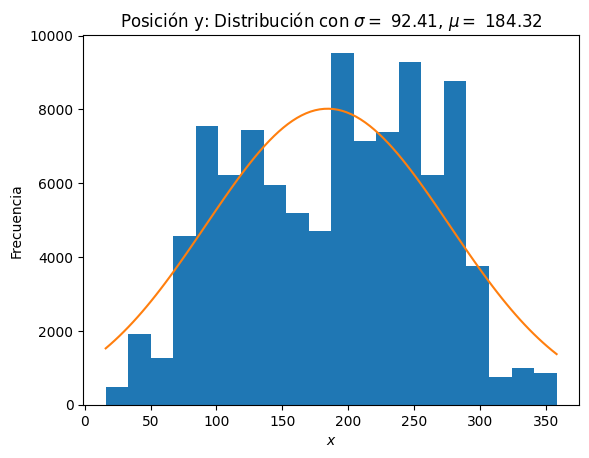

In [87]:
# Ajuste gaussiano para todos los pasos de un caminante
steps = 100000
x0, y0 = randomPosInit(1, 400)
moves2D = randomWalk2D(x0, y0, steps)
plotWalk2D(moves2D)
print(f'Posición inicial: (x={x0}, y={y0})')
histSteps1D(moves2D[0,0,:], desc='Posición x: ')
histSteps1D(moves2D[0,1,:], desc='Posición y: ')

caminantes: 100%|██████████| 100/100 [00:04<00:00, 22.76it/s]


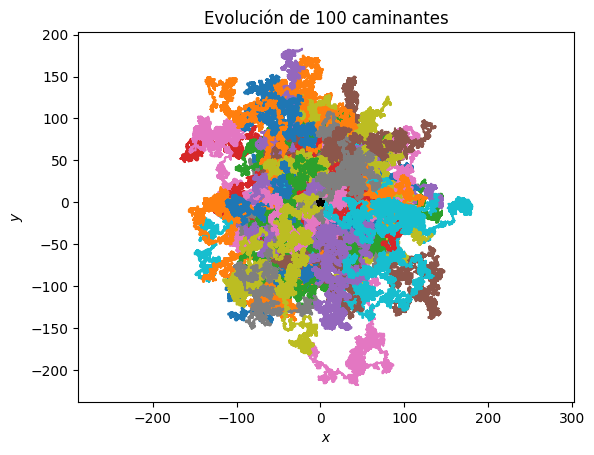

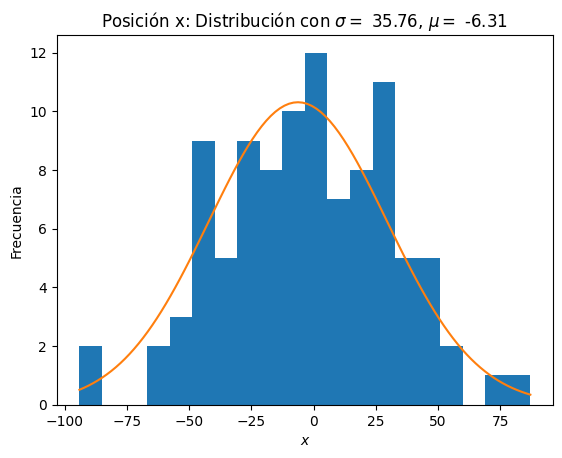

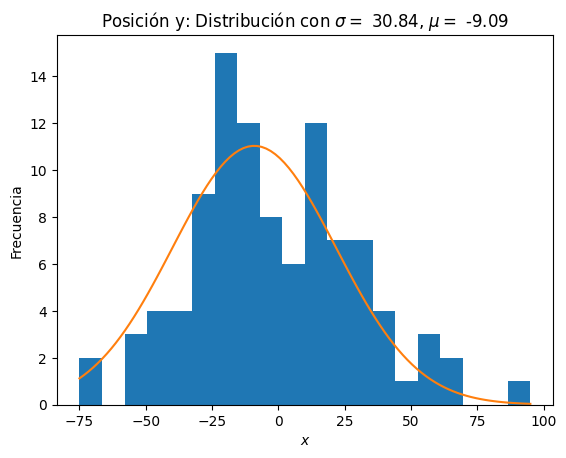

In [88]:
# Ajuste gaussiano para un paso en todos los caminantes. Empezando todos en `(x, y) = (0, 0)`.
steps = 10000
step = 2000
people = 100
xy0 = zeros([people], int)
moves2D = randomWalk2D(xy0, xy0, steps)
plotWalk2D(moves2D)
histSteps1D(moves2D[:,0,step], desc='Posición x: ')
histSteps1D(moves2D[:,1,step], desc='Posición y: ')

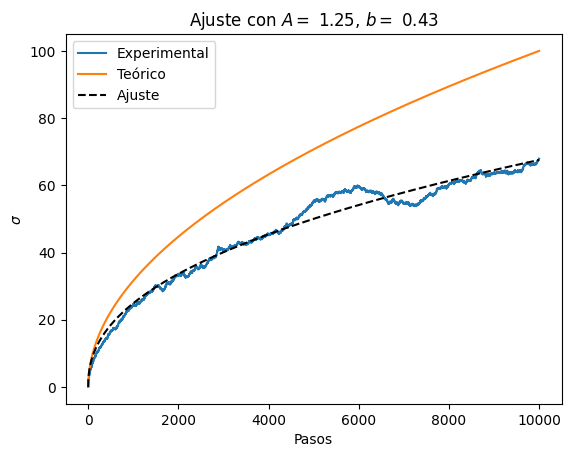

In [89]:
# Si comprobamos como en el caso de 1 dimensión la desviación estándar, observamos que es menor debido a que en algunos pasos se mueven en el eje contrario.
amp, expn = fitStd(moves2D[:,0,:])

**EXTRA**: obtener el histograma bidimensional de la posición, y ajustar esta función de distribución a una superficie gaussiana.

In [90]:
def histSteps2D(moves: ndarray, bins: int = 20):
    hist2d(moves[:,0], moves[:,1], bins=20)
    xlabel('$x$')
    ylabel('$y$')
    title(f'Histograma bidimensional de las posiciones de los caminantes')
    axis('equal')

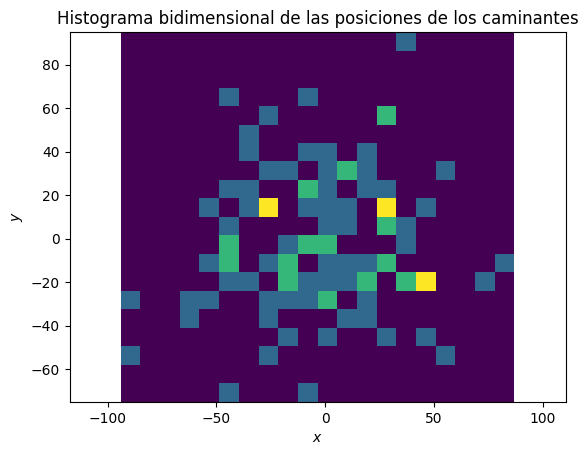

In [91]:
histSteps2D(moves2D[:,:,2000])


## Apartado c

- Obtener un punto del primer cuadrante del plano de forma aleatoria, por ejemplo uno dentro del cuadrado $[10,15]\times[10,15]$. Realizar una caminata de unos 10000 pasos para varias muestras y comprobad cuantas de ellas pasan por ese punto.

- Implementad una estrategia de reseteo, es decir, si después de dar $r$ pasos no hemos llegado al punto buscado volvemos a poner al paseante en el origen y continuamos hasta hacer el total de 10000 pasos. Para varios valores de $r$ obtener la fracción de paseantes que alcanzan el punto objetivo y representad los resultados. **EXTRA**: Para cada valor de $r$ repetid varias veces el experimento de simular $M$ paseantes para puntos del primer cuadrante y obtener la curva anterior con una estimación de los errores en las medidas.

In [92]:
def inPosition(moves, x: int, y: int) -> ndarray:
    """
    Comprueba cuántas veces ha pasado cada caminante por las coordenadas dadas.

    Inputs
    ------
    moves : ndarray
        Array de posiciones de los caminantes.
    x, y : int
        Coordenadas a buscar.

    Outputs
    -------
    inPositionArray : ndarray
        Array que almacena cuántas veces ha pasado cada caminante por las coordenadas.
    """
    people = moves.shape[0]
    steps = moves.shape[2]
    inPositionArray = zeros([people], int)
    for person in range(people):
        for step in range(steps):
            inPositionArray[person] += int((moves[person,0,step] == x) and (moves[person,1,step] == y))

    return inPositionArray

def randomWalk2DReset(people: int, maxStepsOut: int, steps: int) -> ndarray:
    """
    Realiza una caminata utilizando `randomWalk2D`, devolviendo a los caminantes al origen tras la cantidad de pasos indicada.

    Inputs
    ------
    people : int
        Cantidad de caminantes.
    maxStepsOut : int
        Pasos permitidos antes de devolver los caminantes al origen.
    steps : int
        Cantidad total de pasos.

    Outputs
    -------
    moves : ndarray
        Array de posiciones de los caminantes.
    """
    finalSteps = steps % maxStepsOut
    mSOIterations = steps // maxStepsOut
    xy0 = zeros([people], int)
    moves = zeros([people, 2, steps])
    for i in range(mSOIterations):
        moves[:,:,i*maxStepsOut:(i+1)*maxStepsOut] = randomWalk2D(xy0, xy0, maxStepsOut)
        clear_output()  # para que no se llene la consola de barras de progreso
    if finalSteps != 0:
        moves[:,:,(steps-finalSteps):] = randomWalk2D(xy0, xy0, finalSteps)
        clear_output()  # para que no se llene la consola de barras de progreso
    return moves

caminantes: 100%|██████████| 10/10 [00:00<00:00, 556.86it/s]

[0 0 0 0 0 0 0 0 0 0]


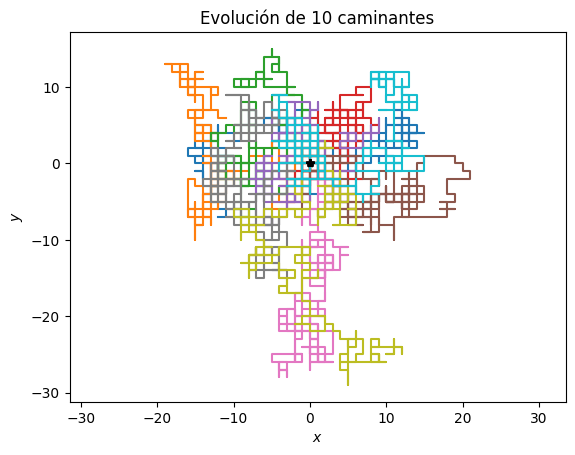

In [93]:
# Dejamos evolucionar a los caminantes y después miramos cuántas veces ha pasado cada uno por un punto concreto.
people = 10
steps = 400
x0 = zeros([people], int)
y0 = zeros([people], int)

moves2D = randomWalk2D(x0, y0, steps)                         # evolución de caminantes
inPos = inPosition(moves2D, randint(10,16), randint(10,16))   # comprobación

print(inPos)        # array con las veces que cada caminante pasa por el punto
plotWalk2D(moves2D) # gráfico

[ 0  3  0  0  0  0  0  0  1  1  2  1  0  0  0  0  0  6  1  5  1  0  0  5
  0  0  0 11  1  0  1  0  2  0  9  0  0  4  4  2  1  2  1  0  1  0  0  1
  1  0  0  9  1  1  0  1  2  2  0  1  2  1  0  0  0  2  0  1  0  0  0  2
  4  0  0  4  2  2  1  0  0  3  0  0  0  6  0  2  0  1  1  0  0  0  0  0
  2  0  0  1]
0.48


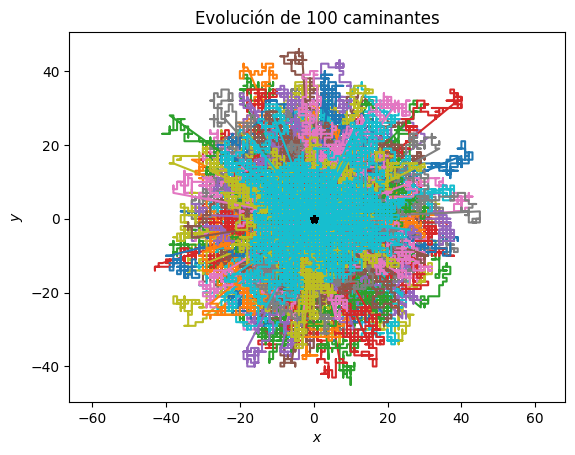

In [94]:
# Dejamos evolucionar a los caminantes `r` (`maxStepsOut`) pasos y les devolvemos al origen.
# Esto se repite hasta que evolucionan `steps` cantidad de pasos.
# No importa si ya han pasado por el punto, estos evolucionan también.
# Usando el mismo principio de antes, usamos `inPosition` para calcular las veces que cada caminante pasa por el punto.
people = 100
steps = 10000
maxStepsOut = 300

movesReset = randomWalk2DReset(people, maxStepsOut, steps)      # evolución con reseteo al origen
inPos = inPosition(movesReset, randint(10,16), randint(10,16))  # comprobación de posición

print(inPos)                                    # array con las veces que cada caminante pasa por el punto
fraction = sum(inPos.astype(bool))/len(inPos)   # solo nos interesa si es distinto de 0, por tanto lo pasamos a `bool` y hacemos la fracción
print(fraction)                                 # fracción de caminantes que han pasado al menos una vez por el punto en algún momento de la evolución.
plotWalk2D(movesReset)                          # gráfico

In [ ]:
# Calculamos la fracción del ejemplo anterior para distintos valores de `r` (`maxStepsOut`).
"""

steps = 10000
maxStepsOut = array([10, 50, 100, 300, 500, 1000, 2500, 5000, 7500, 10000])
x = randint(10,16)
y = randint(10,16)
fractionReset = zeros([len(maxStepsOut)], float)

for i in range(len(maxStepsOut)):
    movesReset = randomWalk2DReset(people, maxStepsOut[i], steps)
    inPos = inPosition(movesReset, x, y).astype(bool)
    fractionReset[i] = sum(inPos)/len(inPos)

save('fractionReset', fractionReset)
"""

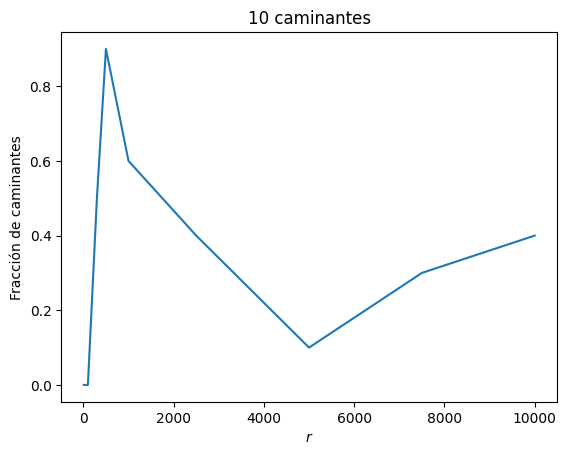

In [97]:
# Cargado de datos
people = 10
maxStepsOut = array([10, 50, 100, 300, 500, 1000, 2500, 5000, 7500, 10000])
fractionReset = load('fractionReset.npy')

# Representación
plot(maxStepsOut, fractionReset)
xlabel('$r$')
ylabel('Fracción de caminantes')
title(f"{people} caminante{'s'*bool(people-1)}")
show()

In [ ]:
# Calculamos la fracción del ejemplo anterior para distintos valores de `r` (`maxStepsOut`).
# Repetimos el cálculo para una cantidad de simulaciones concreta para poder calcular el error aleatorio.
"""
people = 10
steps = 10000
simulations = 10
maxStepsOut = array([10, 50, 100, 300, 500, 1000, 2500, 5000, 7500, 10000])
x = randint(10,16)
y = randint(10,16)
fractionResetSims = zeros([len(maxStepsOut), simulations], float)

for i in range(simulations):
    for j in range(len(maxStepsOut)):
        moves = randomWalk2DReset(people, maxStepsOut[j], steps)
        inPos = inPosition(moves, x, y).astype(bool)
        fractionResetSims[j, i] = sum(inPos)/len(inPos)

save('fractionResetSims', fractionResetSims)
"""

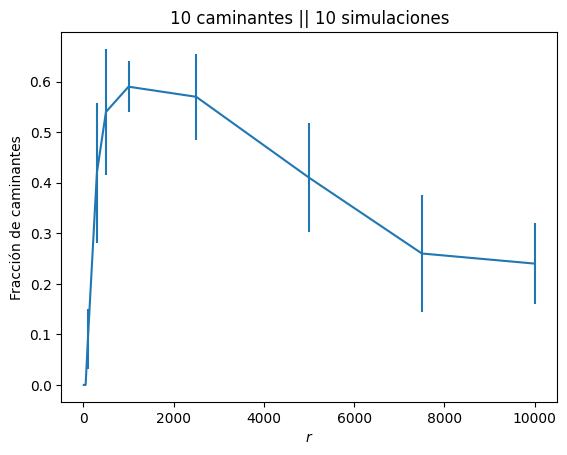

In [98]:
# Cargado de datos y cálculos finales
people = 10
fractionResetSims = load('fractionResetSims.npy')
simulations = 10
randomError = t.ppf((1+0.95)/2, simulations-1)*fractionResetSims.std(axis=1)/simulations**0.5 # error aleatorio usando distribución de t-students
fractionResetSims = fractionResetSims.mean(axis=1)

# Representación
errorbar(maxStepsOut, fractionResetSims, yerr=randomError)
xlabel('$r$')
ylabel('Fracción de caminantes')
title(f"{people} caminante{'s'*bool(people-1)} || {simulations} simulaciones")
show()

#### Conclusión apartado extra
Los resultados son tal y como se esperaban. Inicialmente, a valores muy pequeños de $r$, los caminantes no dan suficientes pasos como para llegar consistentemente al punto elegido. Al aumentar esta $r$, cada vez más caminantes llegan al punto. Si se continúa aumentando esta variable, la fracción de caminantes disminuye lentamente debido a que los caminantes que han ido en direcciones opuestas al punto elegido no son reseteados. Si alguno se aleja demasiado no llegará nunca de nuevo al punto.